# Génération de mélodies avec un RNN-LSTM - Partie 2 : training
ressource: tuto youtube *Melody generation with RNN-LSTM* de *Valerio Velardo*

In [1]:
import os
import music21 as m21
import json
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt

### Paramètres

In [2]:
SEQUENCE_LENGTH = 64
FILE_DATASET_PATH = "data/han/file_dataset"
MAPPINGS_PATH = "data/han/mapping.json"

OUTPUT_UNITS = 31 # Nb de lignes dans fichier mapping
NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001

EPOCHS = 50
BATCH_SIZE = 64

MODEL_PATH = "model_RNN_LSTM.keras"

charger fichier de données et fichier de mapping

In [3]:
def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()
    return song

songs = load(FILE_DATASET_PATH)

def load_json(file_path):
    with open(file_path, "r") as fp:
        mappings = json.load(fp)
    return mappings

mappings = load_json(MAPPINGS_PATH)

In [4]:
print(songs)
# print(songs.split())
print(mappings)
# print(mappings['66'])
# for symbol in songs.split():
#     print(mappings[symbol])

74 _ _ _ 69 _ 72 _ 74 _ _ _ 74 _ _ _ 69 _ _ 72 74 _ 79 _ 72 _ 69 _ 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 67 _ 66 _ 67 _ _ _ 67 _ _ 69 72 _ 74 _ 74 _ _ _ 72 _ 74 _ 67 _ _ _ 62 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 72 _ _ 69 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 67 _ _ _ 67 _ _ _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ 58 _ 60 _ 62 _ _ _ _ _ _ _ 67 _ _ _ 67 _ _ _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ 58 _ 60 _ 62 _ _ _ _ _ _ _ 72 _ 69 _ 72 _ _ 69 67 _ 72 _ 69 _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ _ _ _ _ _ _ 62 _ 62 62 62 _ 67 _ 62 _ 60 _ 58 _ 57 _ 55 _ _ _ _ _ _ _ 60 _ 58 _ _ _ 60 _ 62 _ _ _ _ _ _ _ 67 _ _ _ _ _ _ _ 62 _ _ _ 64 _ 62 _ 60 _ _ _ _ _ 64 _ 62 _ 60 _ 58 _ 57 _ 55 _ _ _ _ _ _ _ / / / / / / / / / / / / / / / / / / / / / / / /

générer séquences d'entrainements

In [5]:
def convert_songs_to_int(songs, mappings):
    # Conversion des datas  74 _ _ _ 69 en integers suivant le mapping
    
    int_songs = []

    songs = songs.split() # 74 _ _ _ 69 --> ['74', '_', '_', '_', '69']

    # map songs to int
    for symbol in songs:
        int_songs.append(mappings[symbol])

    return int_songs

In [6]:
def generate_training_sequences(sequence_length, songs, mappings):
    """Create input and output data samples for training. Each sample is a sequence.

    :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars
    :param songs (string) : songs datas
    :param mappings (dict): mapping between 

    :return inputs (ndarray): Training inputs
    :return targets (ndarray): Training targets
    """

    # map songs to int
    int_songs = convert_songs_to_int(songs, mappings)

    inputs = [] # fenetre qu'on décalle
    targets = [] # note qu'on cherche à prédire à partir de la séquence d'input

    # generate the training sequences
    num_sequences = len(int_songs) - sequence_length
    for i in range(num_sequences):
        inputs.append(int_songs[i:i+sequence_length])
        targets.append(int_songs[i+sequence_length])

    # one-hot encode the sequences
    vocabulary_size = len(set(int_songs))
    # inputs size: (# of sequences, sequence length, vocabulary size)
    inputs = keras.utils.to_categorical(inputs, num_classes=vocabulary_size)
    targets = np.array(targets)

    return inputs, targets

In [7]:
inputs, targets = generate_training_sequences(64, songs, mappings)

### Entrainement

In [8]:
def build_model(output_units, num_units, loss, learning_rate):
    """Builds and compiles model

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply

    :return model (tf model)
    """

    # create the model architecture
    input = keras.layers.Input(shape=(None, output_units))
    x = keras.layers.LSTM(num_units[0])(input)
    x = keras.layers.Dropout(0.2)(x)

    output = keras.layers.Dense(output_units, activation="softmax")(x)

    model = keras.Model(input, output)

    # compile model
    model.compile(loss=loss,
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    model.summary()

    return model

In [9]:
# build the model
model = build_model(OUTPUT_UNITS, NUM_UNITS, LOSS, LEARNING_RATE)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 31)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,879 (1.16 MB)

 Trainable params: 302,879 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# train the model

history = model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.6352 - loss: 1.6219
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.6938 - loss: 1.1234
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.6950 - loss: 0.9667
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.7039 - loss: 0.9301
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.7093 - loss: 0.9131
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.7208 - loss: 0.8832
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.7274 - loss: 0.8697
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.7330 - loss: 0.8358
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.7463 - loss: 0.8002
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.7420 - loss: 0.8037
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.7477 - loss: 0.7823
Epoch 12/50
291/291 ━━━━━━━━━━

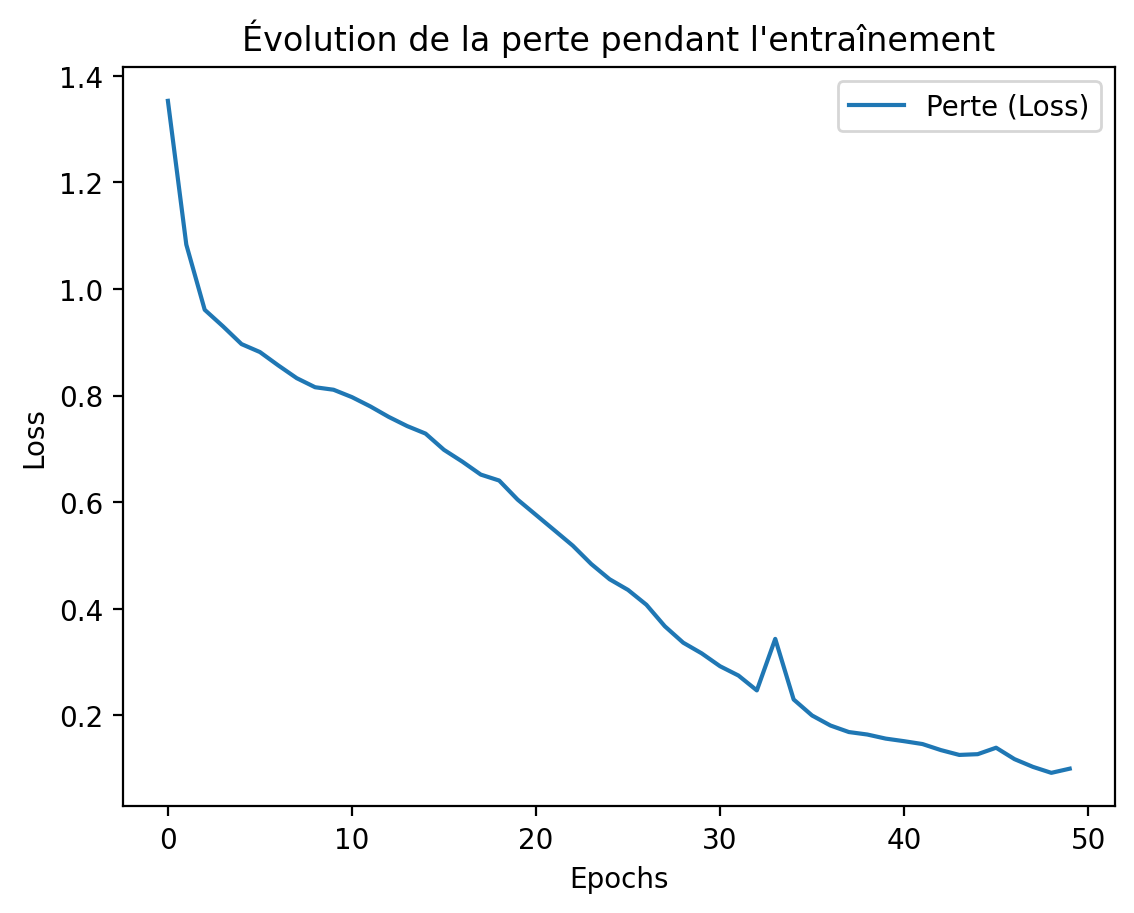

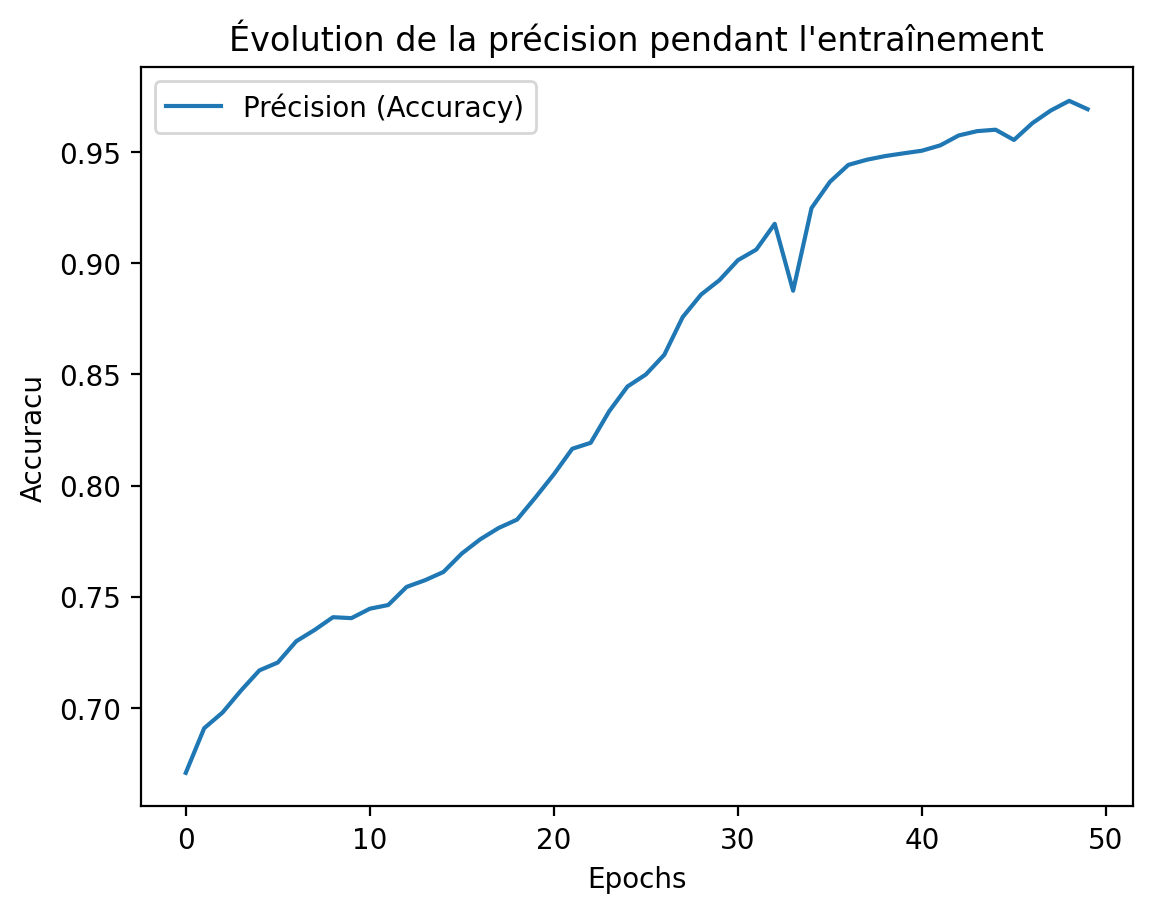

In [11]:
# Affichage de la loss
plt.plot(history.history['loss'], label='Perte (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Évolution de la perte pendant l'entraînement")
plt.legend()
plt.show()

# Affichache accuracy
plt.plot(history.history['accuracy'], label='Précision (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracu')
plt.title("Évolution de la précision pendant l'entraînement")
plt.legend()
plt.show()

In [12]:
# save the model
model.save(MODEL_PATH)